In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
from keras.datasets import reuters

# 1. 데이터 셋

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [4]:
len(train_data), len(test_data)

(8982, 2246)

### Text Decoding

In [5]:
word_index = reuters.get_word_index(path='reuters_word_index.npz')
reverse_word_index = {index: word for word, index in word_index.items()}
' '.join(reverse_word_index.get(index - 3, '?') for index in train_data[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

# 2. 데이터 준비

### vectorize encoding

In [6]:
import numpy as np

def vectorize_sequences(sequences, dimensions=10000):
    seq_matrix = np.zeros((len(sequences), dimensions))
    
    for i, sequence in enumerate(sequences):
        seq_matrix[i, sequence] = 1.
    return seq_matrix

In [7]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### one hot encoding

In [8]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [9]:
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [10]:
# keras에는 이미 내장 함수 존재
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

# 3. 모델 구성

In [11]:
from keras import models
from keras import layers

- Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만을 사용할 수 있다.
- 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없다.
- 각 층은 잠재적으로 정보의 병목이 될 수 있다. 예제 2에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있다.

In [12]:
model = models.Sequential()

# bottleneck
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 훈련 검증

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
partial_x_train, partial_x_val, partial_y_train, partial_y_val = train_test_split(x_train, 
                                                                                  one_hot_train_labels,
                                                                                  test_size=0.2)

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(partial_x_val, partial_y_val))

Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 2s 309us/step - loss: 2.6192 - acc: 0.4984 - val_loss: 1.7934 - val_acc: 0.5921
Epoch 2/20
7185/7185 [==============================] - 1s 132us/step - loss: 1.4959 - acc: 0.6738 - val_loss: 1.5506 - val_acc: 0.6194
Epoch 3/20
7185/7185 [==============================] - 1s 131us/step - loss: 1.1635 - acc: 0.7443 - val_loss: 1.2805 - val_acc: 0.7112
Epoch 4/20
7185/7185 [==============================] - 1s 132us/step - loss: 0.9361 - acc: 0.7992 - val_loss: 1.2311 - val_acc: 0.7201
Epoch 5/20
7185/7185 [==============================] - 1s 133us/step - loss: 0.7672 - acc: 0.8391 - val_loss: 1.1271 - val_acc: 0.7462
Epoch 6/20
7185/7185 [==============================] - 1s 131us/step - loss: 0.6251 - acc: 0.8700 - val_loss: 1.0428 - val_acc: 0.7713
Epoch 7/20
7185/7185 [==============================] - 1s 143us/step - loss: 0.5129 - acc: 0.8938 - val_loss: 0.9938 - val_acc: 0.7835


In [17]:
import matplotlib.pyplot as plt

### Loss

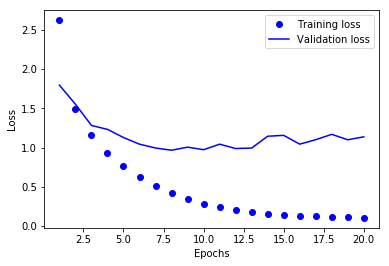

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Acc

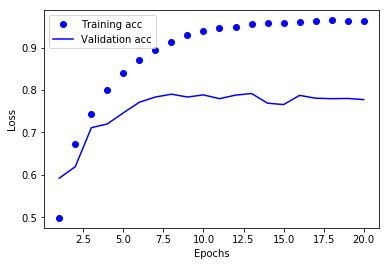

In [33]:
loss = history.history['acc']
val_loss = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 5. 예측

In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(partial_x_train,
          partial_y_train, 
          epochs=9,
          batch_size=512,
          validation_data=(partial_x_val, partial_y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7185 samples, validate on 1797 samples
Epoch 1/9
7185/7185 [==============================] - 1s 195us/step - loss: 2.6449 - acc: 0.4640 - val_loss: 1.8182 - val_acc: 0.6138
Epoch 2/9
7185/7185 [==============================] - 1s 140us/step - loss: 1.4721 - acc: 0.6874 - val_loss: 1.4135 - val_acc: 0.6962
Epoch 3/9
7185/7185 [==============================] - 1s 142us/step - loss: 1.1061 - acc: 0.7637 - val_loss: 1.2382 - val_acc: 0.7206
Epoch 4/9
7185/7185 [==============================] - 1s 139us/step - loss: 0.8816 - acc: 0.8160 - val_loss: 1.1821 - val_acc: 0.7273
Epoch 5/9
7185/7185 [==============================] - 1s 140us/step - loss: 0.7186 - acc: 0.8448 - val_loss: 1.2567 - val_acc: 0.7078
Epoch 6/9
7185/7185 [==============================] - 1s 139us/step - loss: 0.5947 - acc: 0.8733 - val_loss: 1.0378 - val_acc: 0.7874
Epoch 7/9
7185/7185 [==============================] - 1s 138us/step - loss: 0.4859 - acc: 0.9012 - val_loss: 1.0271 - val_acc: 0.7858
Epoch 8

In [35]:
results

[1.1793704340740283, 0.72484416743526481]

- 무작위 예측 시에

In [37]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.1803205699020481

# 6. 레이블과 손실을 다루는 다른 방법

- 정수로 인코딩하고 sparse_categorical_crossentropy로 사용한다.

In [42]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

# 7. 충분히 큰 중간층을 두어야 하는 이유

In [44]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(partial_x_train,
          partial_y_train, 
          epochs=20,
          batch_size=512,
          validation_data=(partial_x_val, partial_y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 2s 248us/step - loss: 3.5710 - acc: 0.0585 - val_loss: 3.3038 - val_acc: 0.3278
Epoch 2/20
7185/7185 [==============================] - 1s 140us/step - loss: 3.0670 - acc: 0.4032 - val_loss: 2.9436 - val_acc: 0.3984
Epoch 3/20
7185/7185 [==============================] - 1s 138us/step - loss: 2.6709 - acc: 0.4543 - val_loss: 2.6471 - val_acc: 0.4263
Epoch 4/20
7185/7185 [==============================] - 1s 139us/step - loss: 2.3372 - acc: 0.4770 - val_loss: 2.4142 - val_acc: 0.4274
Epoch 5/20
7185/7185 [==============================] - 1s 138us/step - loss: 2.0687 - acc: 0.4868 - val_loss: 2.2154 - val_acc: 0.4313
Epoch 6/20
7185/7185 [==============================] - 1s 138us/step - loss: 1.8583 - acc: 0.4912 - val_loss: 2.0684 - val_acc: 0.4385
Epoch 7/20
7185/7185 [==============================] - 1s 137us/step - loss: 1.6771 - acc: 0.5091 - val_loss: 1.9317 - val_acc: 0.4652


- 이와 같은 손실 원인 대부분은 많은 정보를 중간층의 저차원 표현 공간으로 압축시키려 했기 때문이다. 이 네트워크는 필요한 정보 대부분을 4차원으로 구겨 넣었지만 전부는 넣지 못했습니다.

# 8. 추가 실험

In [45]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(partial_x_train,
          partial_y_train, 
          epochs=9,
          batch_size=512,
          validation_data=(partial_x_val, partial_y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Train on 7185 samples, validate on 1797 samples
Epoch 1/9
7185/7185 [==============================] - 1s 199us/step - loss: 2.6660 - acc: 0.4459 - val_loss: 1.8085 - val_acc: 0.5771
Epoch 2/9
7185/7185 [==============================] - 1s 136us/step - loss: 1.4618 - acc: 0.6788 - val_loss: 1.4649 - val_acc: 0.6661
Epoch 3/9
7185/7185 [==============================] - 1s 153us/step - loss: 1.1413 - acc: 0.7392 - val_loss: 1.2733 - val_acc: 0.7134
Epoch 4/9
7185/7185 [==============================] - 1s 158us/step - loss: 0.9184 - acc: 0.7996 - val_loss: 1.2144 - val_acc: 0.7195
Epoch 5/9
7185/7185 [==============================] - 1s 139us/step - loss: 0.7521 - acc: 0.8347 - val_loss: 1.1299 - val_acc: 0.7602
Epoch 6/9
7185/7185 [==============================] - 1s 136us/step - loss: 0.6205 - acc: 0.8615 - val_loss: 1.2540 - val_acc: 0.7190
Epoch 7/9
7185/7185 [==============================] - 1s 150us/step - loss: 0.5004 - acc: 0.8920 - val_loss: 1.0527 - val_acc: 0.7730
Epoch 8

# 9. 정리

- N 개 클래스로 데이터 포인트를 분류하려면 네트워크 마지막 Dense층 크기는 N이어야 한다.
- 단일 레이블, 다층 분류 문제에서는 N개 클래스에 대한 확률 분포 출력을 위해 softmax 활성화 함수 사용이 필요하다.
- 이런 문제에는 항상 범주형 크로스엔트로피를 이용해야 한다.
- 다중 분류에서 레이블을 다루는 두 가지 방법이 있다.
    - 레이블을 범주형 인코딩으로 인코딩하고 categorical_crossentropy 손실 함수를 사용한다.
    - 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실 함수를 사용한다.
    
- 많은 수의 범주를 분류할 때 중간 층의 크기가 너무 작아 정보의 병목이 생기지 않도록 한다.